In [66]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F

324.8915389789102


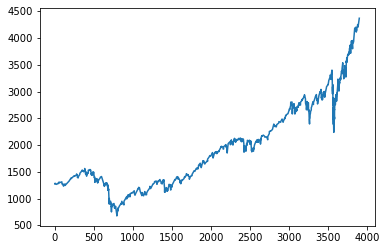

In [67]:
# ---- data loading and pre-processing ---- #

import polar_pla as pla
import numpy as np
import torch
from torch.autograd import Variable

# read in time series into temporary list
temp = []
f = open('DataSets/snp500.csv', 'r')
for line in f:
    temp.append(float(line))

# run bottom up piecewise linear approximation on that list and store processed values
data = pla.bottom_up_pla(temp,1000)
#print(data)
# set the sequence length (the number of trends we look at to predict the next) and the train to test ratio
seq_length = 12
train_proportion = 0.8

# segment the data into input output pairs that we will use to train the model
def sliding_window(data):
    inputs = []
    outputs = []
    for i in range(0, len(data)-seq_length, 2):
        inputs.append(data[i:(i+seq_length)]) # the next n are the input
        outputs.append(data[i+seq_length:i+seq_length+2]) # and the one after that is the output
    return Variable(torch.Tensor(np.array(inputs))), Variable(torch.Tensor(np.array(outputs)))

# convert data to tensor, and apply dataloader
total_data_input, total_data_output = sliding_window(data)
train_size = int(len(total_data_input)*train_proportion)

training_data_input = torch.narrow(total_data_input, 0, 0, train_size)
training_data_output = torch.narrow(total_data_output, 0, 0, train_size)

testing_data_input = torch.narrow(total_data_input, 0, train_size, len(total_data_input) - train_size)
testing_data_output = torch.narrow(total_data_output, 0, train_size, len(total_data_input) - train_size)

train = torch.utils.data.TensorDataset(training_data_input, training_data_output)
test = torch.utils.data.TensorDataset(testing_data_input, testing_data_output)
trainset = torch.utils.data.DataLoader(train, batch_size=32, shuffle=False)
testset = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False)

In [68]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(seq_length, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=12, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)
)


In [69]:
# training

epochs = 2000

import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.0001)
for epoch in range(epochs+1): # 3 full passes over the data
    for data in trainset:  # `data` is a batch of data
        X, y = data  # X is the batch of features, y is the batch of targets.
        net.zero_grad()  # sets gradients to 0 before loss calc. You will do this likely every step.
        output = net(X.view(-1,seq_length))  # pass in the reshaped batch (recall they are 28x28 atm)
        #print(X)
        #print(output, y)
        loss = F.mse_loss(output, y)  # calc and grab the loss value
        loss.backward()  # apply this loss backwards thru the network's parameters
        optimizer.step()  # attempt to optimize weights to account for loss/gradients
    if epoch %(epochs/10) == 0: print(f"Epoch: {epoch}/{epochs}, loss: {loss.item()}")


Epoch: 0/2000, loss: 0.41755130887031555
Epoch: 200/2000, loss: 0.17369641363620758
Epoch: 400/2000, loss: 0.08426862955093384
Epoch: 600/2000, loss: 0.032933712005615234
Epoch: 800/2000, loss: 0.01574384793639183
Epoch: 1000/2000, loss: 0.008291638456285
Epoch: 1200/2000, loss: 0.006395130883902311
Epoch: 1400/2000, loss: 0.005315390881150961
Epoch: 1600/2000, loss: 0.004193412605673075
Epoch: 1800/2000, loss: 0.002956730080768466
Epoch: 2000/2000, loss: 0.0021062109153717756


In [70]:
# test
'''import matplotlib.pyplot as plt
with torch.no_grad():
    av_loss = 0 
    i = 0
    X, Y = [], []
    X2, Y2 = [], []
    for data in test:
        inputs, labels = data
        output = net(inputs.view(-1,8))[0]

        X.append(float(output[0]))
        Y.append(float(output[1]))
        X2.append(float(labels[0]))
        Y2.append(float(labels[1]))

    plt.plot(X, Y)
    plt.plot(X2,Y2)
    plt.show()'''
with torch.no_grad():
    correct = 0
    i = 0
    X, Y = [], []
    X2, Y2 = [], []
    total_loss = 0
    for data in test:
        inputs, labels = data
        output = net(inputs.view(-1,seq_length))
        net.zero_grad()
        total_loss += F.mse_loss(output[0], labels).item()
        output = output[0]
        if output[0] < 0 and labels[0] < 0 or output[0] > 0 and labels[0] > 0:
            correct += 1
            #print(output[0],labels[0])
    print(f'Directional Accuracy: {correct*100/len(test)}, Average Loss: {total_loss/len(test)}')




Directional Accuracy: 55.95238095238095, Average Loss: 0.9095609580815237
